<a href="https://colab.research.google.com/github/minichan5/Detection/blob/master/custom_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection in Google Colab with Fizyr Retinanet

Jupyter notebook providing steps to train a Keras/Tensorflow model for object detection with custom dataset.

It runs in Google Colab using [Fizyr implementation](https://github.com/fizyr/keras-retinanet) of RetinaNet in Keras.

Requirements are only dataset images and annotations file made in [LabelImg](https://github.com/tzutalin/labelImg).

Colab Runtime type: Python3, GPU enabled.

# Environment Setup
Download and install in Colab required packages and import libraries.

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git


Cloning into 'keras-retinanet'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 5355 (delta 10), reused 13 (delta 6), pack-reused 5329
Receiving objects: 100% (5355/5355), 13.32 MiB | 6.64 MiB/s, done.
Resolving deltas: 100% (3569/3569), done.


In [2]:
%cd keras-retinanet/

!pip install .
!pip install keras==2.3


/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=169842 sha256=0b749f7edfecb93dffa5073d7818a819a6c931c84f8cb7a6955ea2ef9f0df008
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13344 sha256=5478ff737cccee42ea58a0231fc81af532a7c46160d3d26d885b58ed592596e4
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet
     |████████████████████████████████| 378kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [3]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [0]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

# Making Dataset

Download from Drive training dataset, and convert it to Fizyr annotations format.

Before upload in Google Drive a zip file containing annotations and images for training dataset, with following format (check my zip sample):

```
objdet_reduced_dataset.zip
|- img1.jpg
|- img1.xml
|- img2.jpg
|- img2.xml
...
```

Then change accordingly DATASET_DRIVEID.

In [0]:
#DATASET_DRIVEID = '1eipoh0OlEPwzzP72tna3wQU_RJ4oDJdf'

#https://drive.google.com/open?id=1eipoh0OlEPwzzP72tna3wQU_RJ4oDJdf



In [5]:
!wget https://github.com/RomRoc/objdet_fizyr_colab/raw/master/goat_dataset.zip


--2019-11-27 16:48:22--  https://github.com/RomRoc/objdet_fizyr_colab/raw/master/goat_dataset.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/RomRoc/objdet_fizyr_colab/master/goat_dataset.zip [following]
--2019-11-27 16:48:23--  https://raw.githubusercontent.com/RomRoc/objdet_fizyr_colab/master/goat_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13060393 (12M) [application/zip]
Saving to: ‘goat_dataset.zip’

goat_dataset.zip    100%[===================>]  12.46M  77.1MB/s    in 0.2s    

2019-11-27 16:48:23 (77.1 MB/s) - ‘goat_dataset.zip’ saved [13060393/13060393]



In [6]:
!ls


build		 goat_dataset.zip  LICENSE	     setup.cfg	tests
CONTRIBUTORS.md  images		   README.md	     setup.py
examples	 keras_retinanet   requirements.txt  snapshots


In [0]:
file_name =  'goat_dataset.zip'

In [0]:
DATASET_DIR = 'dataset'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [9]:
#drive_url = 'https://drive.google.com/uc?export=download&id=' + DATASET_DRIVEID
#file_name = DATASET_DRIVEID + '.zip'

#urllib.request.urlretrieve(drive_url, file_name)
#print('Download completed!')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from zipfile import ZipFile
from shutil import copy

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

os.makedirs(DATASET_DIR, exist_ok=True)
#downloaded = drive.CreateFile({'id': DATASET_DRIVEID})
#downloaded.GetContentFile(file_name)
ds = ZipFile(file_name)
ds.extractall(DATASET_DIR)
os.remove(file_name)
print('Extracted zip file ' + file_name)



Extracted zip file goat_dataset.zip


In [0]:
annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

# Training Model

Download pretrained model and run training.

In the next cell choose one option:

1.   download Fizyr Resnet50 pretrained model
2.   download your custom pretrained model, to continue previous training epochs

In the last cell optionally export trained model to Google Drive.


In [11]:
!pwd

/content/keras-retinanet


In [12]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

#### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
#drive.mount('/content/gdrive')
#DRIVE_MODEL = '/content/gdrive/My Drive/Colab Notebooks/objdet_tensorflow_colab/resnet50_csv_10.h5'
#shutil.copy(DRIVE_MODEL, PRETRAINED_MODEL)


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


In [13]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

Using TensorFlow backend.
Creating model, this may take a second...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((3, 3, 256, 9) vs (720, 256, 3, 3)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1316: UserWarning: Skipping loading of weights for layer classification_submodel due to mismatch in shape ((9,) vs (720,)).
  weight_values[i].shape))
2019-11-27 16:49:15.709469: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2019-11-27 16:49:15.760951: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-11-27 16:49:15.761802: I tensorflow/co

In [0]:
#### OPTIONAL: EXPORT TRAINED MODEL TO DRIVE ####
#drive.mount('/content/gdrive')
#COLAB_MODEL = './snapshots/resnet50_csv_10.h5'
#DRIVE_DIR = '/content/gdrive/My Drive/Colab Notebooks/objdet_tensorflow_colab/'
#shutil.copy(COLAB_MODEL, DRIVE_DIR)

# Inference
Run inference with uploaded image on trained model.

In [0]:
THRES_SCORE = 0.8

In [0]:
%tensorflow_version 1.x 

In [17]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [18]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_10.h5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_1:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_2:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_3:0' shape=(9, 4) dtype=float32> anchors
tracking <tf.Variable 'Variable_4:0' shape=(9, 4) dtype=float32> anchors


In [0]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

In [20]:

uploaded = files.upload()


Saving 20190220_155741.jpg to 20190220_155741.jpg
Saving 20190220_155839.jpg to 20190220_155839.jpg


Running inference on: 20190220_155741.jpg
processing time:  3.0360255241394043


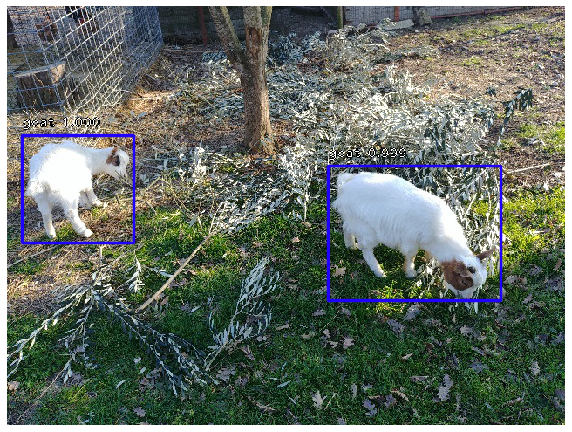

In [21]:
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)

Running inference on: 20190220_155839.jpg
processing time:  0.06709933280944824


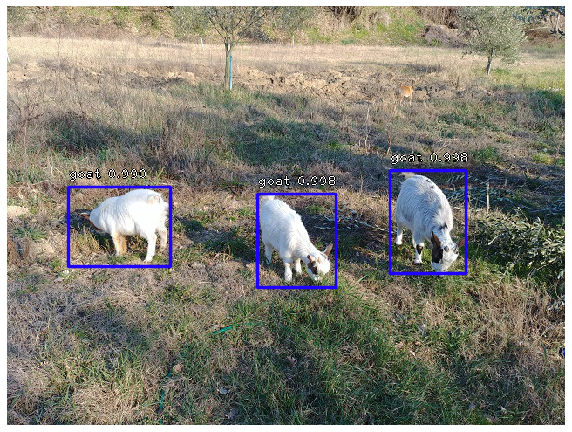

In [22]:
img_infer = list(uploaded)[1]

print('Running inference on: ' + img_infer)
img_inference(img_infer)